# 20Newsgroup documents

This sections aims to use the packages functionality on text data. This includes creating a amtrix of tf-idf features, PCA and hierarchical clustering. For this, we will demonstrate on a sample of the [20Newsgroup data](https://qwone.com/~jason/20Newsgroups/). Each document is associated with 1 of 20 newsgroup topics, organized at two
hierarchical levels.

In [1]:
import pandas as pd
import numpy as np
import pyemb as eb
import matplotlib.pyplot as plt

## Data load

Import data and create dataframe.

In [2]:
df = eb.load_newsgroup()

Data loaded successfully


`eb.text_matrix_and_attributes` - creates a Y matrix of tf-idf features. It takes in a dataframe and the column which contains the data. Further functionality includes: removing general stopwords, adding stopwords, removing email addresses, cleaning (lemmatize and remove symbol, lowercase letters) and a threshold for the min/max number of documents a word needs to appear in to be included.

In [3]:
Y, attributes = eb.text_matrix_and_attributes(df, 'data', remove_stopwords=True, clean_text=True,
                                    remove_email_addresses=True, update_stopwords=['subject'],
                                    min_df=5, max_df=len(df)-1000)

In [4]:
(n,p) = Y.shape
print("n = {}, p = {}".format(n,p))

n = 5000, p = 12804


Perform dimension selection using Wasserstein distances, see [Whiteley et al., 2022](https://arxiv.org/pdf/2208.11665) for details.

In [5]:
ws, dim = eb.wasserstein_dimension_select(Y, range(40), split=0.5)

In [ ]:
dim = 28

In [6]:
print("Selected dimension: {}".format(dim))

Selected dimension: 28


## PCA and tSNE

Now we perform PCA [Whiteley et al., 2022](https://arxiv.org/pdf/2208.11665).

In [7]:
zeta = p**-.5 * eb.embed(Y, d=dim, version='full')

Apply t-SNE.

In [8]:
from sklearn.manifold import TSNE

tsne_zeta = TSNE(n_components=2, perplexity=30).fit_transform(zeta)

Colours dictionary where topics from the same theme have different shades of the same colour

In [9]:
target_colour = {'alt.atheism': 'goldenrod',
                 'comp.graphics': 'steelblue',
                 'comp.os.ms-windows.misc': 'skyblue',
                 'comp.sys.ibm.pc.hardware': 'lightblue',
                 'comp.sys.mac.hardware': 'powderblue',
                 'comp.windows.x': 'deepskyblue',
                 'misc.forsale': 'maroon',
                 'rec.autos': 'limegreen',
                 'rec.motorcycles': 'green',
                 'rec.sport.baseball': 'yellowgreen',
                 'rec.sport.hockey': 'olivedrab',
                 'sci.crypt': 'pink',
                 'sci.electronics': 'plum',
                 'sci.med': 'orchid',
                 'sci.space': 'palevioletred',
                 'soc.religion.christian': 'darkgoldenrod',
                 'talk.politics.guns': 'coral',
                 'talk.politics.mideast': 'tomato',
                 'talk.politics.misc': 'darksalmon',
                 'talk.religion.misc': 'gold'}

Plot PCA on the LHS and PCA + t-SNE on the RHS

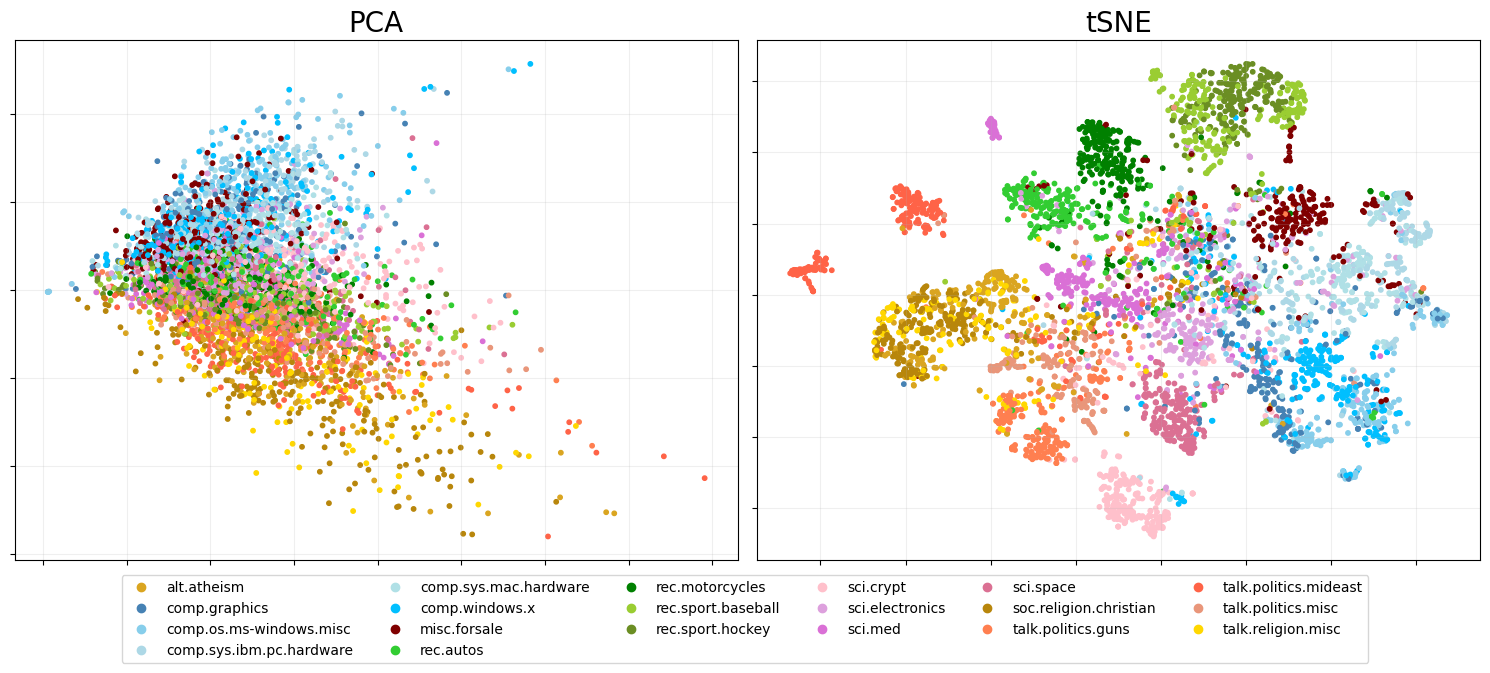

In [10]:
pca_fig = eb.snapshot_plot(
    embedding = [zeta[:, :2],tsne_zeta], 
    node_labels = df['target_names'].tolist(), 
    c = target_colour,
    title = ['PCA','tSNE'],
    
    add_legend=True, 
    max_legend_cols = 6,
    figsize = (15,6),
    move_legend = (.5,-.15),
    # tick_labels = True, 
    # Apply other matplotlib settings
    s=10,
)
plt.tight_layout()

## Hierarchical clustering with dot products, [Gray et al., 2024](https://proceedings.neurips.cc/paper_files/paper/2023/file/6521937507d78f327cd402401be73bf2-Paper-Conference.pdf)

First we do HC for the centroids of each topic and plot the dendrogram. Then we do HC on the whole dataset and visualise the output tree. 

## On centroids

Find centroids

In [11]:
idxs = [np.where(np.array(df['target']) == t)[0]
        for t in sorted(df['target'].unique())]
t_zeta = np.array([np.mean(zeta[idx, :], axis=0) for idx in idxs])

Topic HC clustering

In [12]:
t_dp_hc = eb.DotProductAgglomerativeClustering()
t_dp_hc.fit(t_zeta);

Plot dendrogram

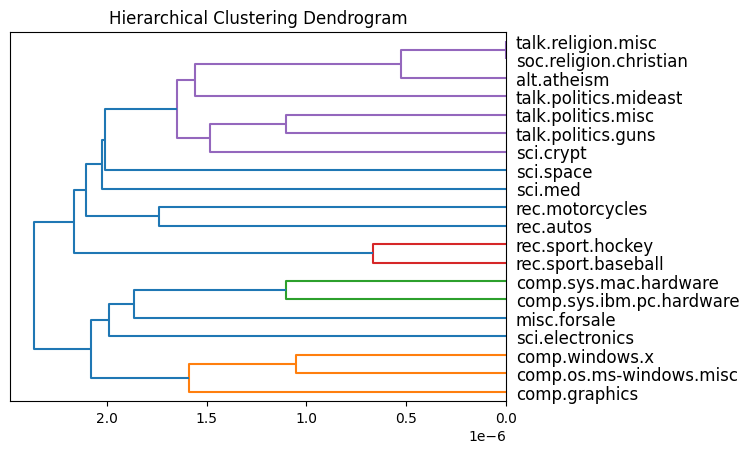

In [13]:
plt.title("Hierarchical Clustering Dendrogram")
eb.plot_dendrogram(t_dp_hc, dot_product_clustering=True, orientation='left',
                   labels=sorted(df['target_names'].unique()))
plt.show()

## On documents

In [14]:
dp_hc = eb.DotProductAgglomerativeClustering()
dp_hc.fit(zeta);

Use construct tree graph from hierarchical clustering, epsilon is set to zero as we don't want to prune the tree.

In [15]:
tree = eb.ConstructTree(model= dp_hc, epsilon=0)
tree.fit()

Constructing tree...


100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


BarnesHut Approximation  took  6.12  seconds
Repulsion forces  took  4.49  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


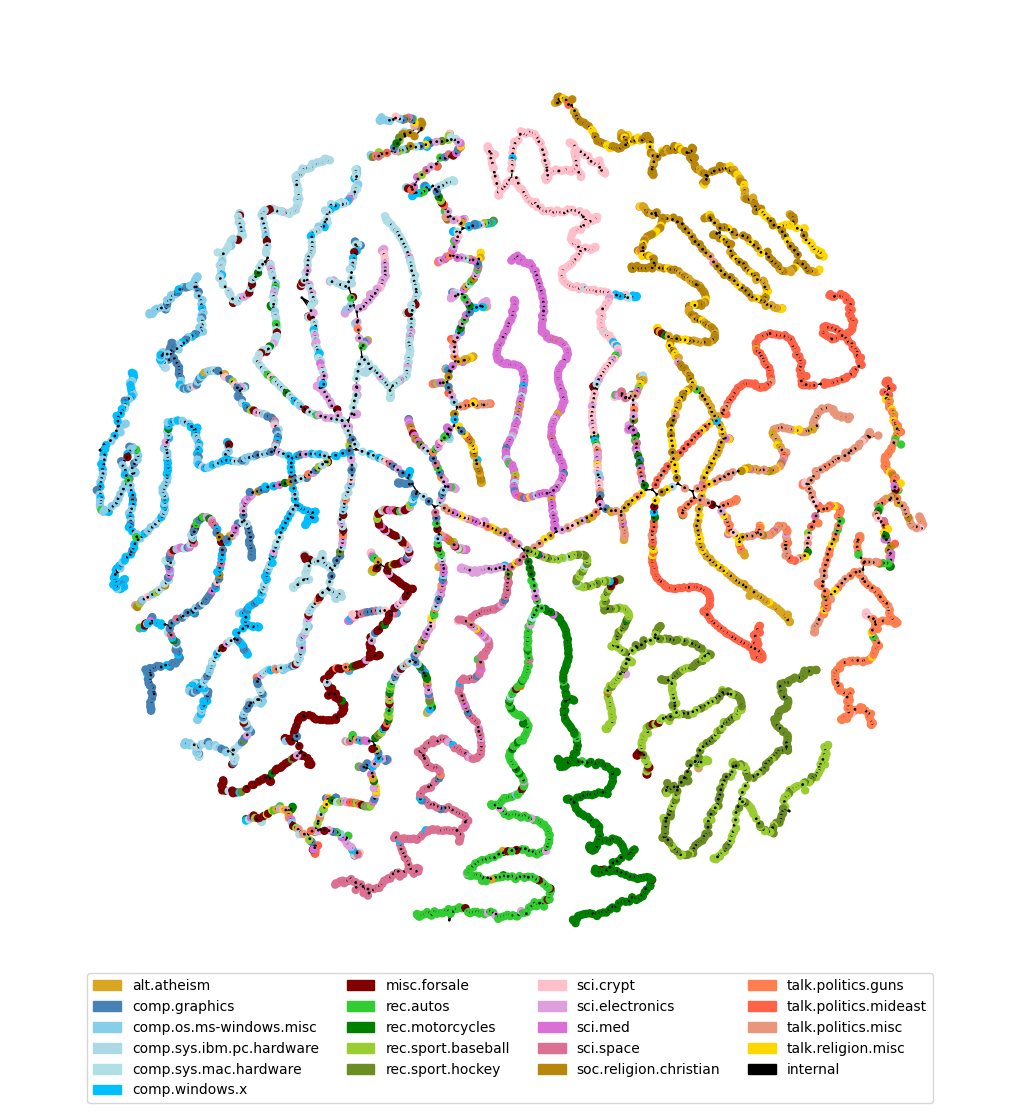

In [19]:
tree.plot(labels = list(df["target_names"]), colours = target_colour, node_size=25, forceatlas_iter=100)


## References


* Whiteley, N., Gray, A. and Rubin-Delanchy, P., 2022. Statistical exploration of the Manifold Hypothesis.

* Gray, A., Modell, A., Rubin-Delanchy, P. and Whiteley, N., 2024. Hierarchical clustering with dot products recovers hidden tree structure. Advances in Neural Information Processing Systems, 36.